## T1 Weighted MRI Generation using DCGAN

    In this Notebook we'll build a DCGAN Model to produce MRI Images of type T1.

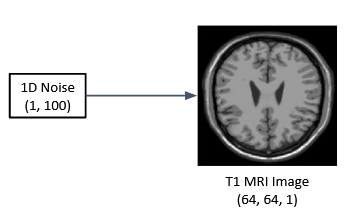

## Pipeline

Lets write down the steps we will be executing sequentially


1. Importing Libraries
2. Data Loading and Visualization
3. Data Preprocessing
4. Model Building
5. Model Training
6. Generating a GIF of Generated Images

### Importing Libraries


Important Libraries and their versions
*   numpy - 1.19.2
*   tensorflow - 2.4.1
*   matplotlib - 3.3.2

In [3]:
# Import Required Libraries here
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import imageio
import glob
from tensorflow.keras.utils import plot_model

### Data Loading and Visualization
1. Data Loading
2. Data Visualization

#### Load the T1 MRI Data

In [4]:
# we resize all MRI images in our dataset to (64, 64) to maintain uniformity across the dataset
# having images size as a power of two also makes our model training faster and more accurate
IMAGE_DIM = 64

To load our images as a tensorflow dataset type, we use tf.keras.preprocessing.image_dataset_from_directory() function. 

This function also allows us to batch the dataset.

In [5]:
!wget https://datasetsgun.s3.amazonaws.com/upgrad/mri.zip

--2021-04-13 08:47:03--  https://datasetsgun.s3.amazonaws.com/upgrad/mri.zip
Resolving datasetsgun.s3.amazonaws.com (datasetsgun.s3.amazonaws.com)... 52.217.104.148
Connecting to datasetsgun.s3.amazonaws.com (datasetsgun.s3.amazonaws.com)|52.217.104.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1825257 (1.7M) [application/zip]
Saving to: ‘mri.zip’

mri.zip             100%[===================>]   1.74M  1.08MB/s    in 1.6s    

2021-04-13 08:47:05 (1.08 MB/s) - ‘mri.zip’ saved [1825257/1825257]



In [6]:
!unzip mri.zip

Archive:  mri.zip
   creating: mri/Tr1/
  inflating: mri/Tr1/.DS_Store       
   creating: mri/Tr1/TrainT1/
  inflating: mri/Tr1/TrainT1/Image #10.png  
  inflating: mri/Tr1/TrainT1/Image #11.png  
  inflating: mri/Tr1/TrainT1/Image #12.png  
  inflating: mri/Tr1/TrainT1/Image #13.png  
  inflating: mri/Tr1/TrainT1/Image #14.png  
  inflating: mri/Tr1/TrainT1/Image #15.png  
  inflating: mri/Tr1/TrainT1/Image #16.png  
  inflating: mri/Tr1/TrainT1/Image #17.png  
  inflating: mri/Tr1/TrainT1/Image #18.png  
  inflating: mri/Tr1/TrainT1/Image #19.png  
  inflating: mri/Tr1/TrainT1/Image #23.png  
  inflating: mri/Tr1/TrainT1/Image #24.png  
  inflating: mri/Tr1/TrainT1/Image #25.png  
  inflating: mri/Tr1/TrainT1/Image #26.png  
  inflating: mri/Tr1/TrainT1/Image #27.png  
  inflating: mri/Tr1/TrainT1/Image #28.png  
  inflating: mri/Tr1/TrainT1/Image #29.png  
  inflating: mri/Tr1/TrainT1/Image #30.png  
  inflating: mri/Tr1/TrainT1/Image #31.png  
  inflating: mri/Tr1/TrainT1/Image #3

In [7]:
tr1 = tf.keras.preprocessing.image_dataset_from_directory('mri/Tr1',
    color_mode='grayscale', batch_size=1, label_mode=None, image_size=(IMAGE_DIM, IMAGE_DIM), shuffle=True, seed=42, interpolation='nearest')

Found 43 files belonging to 1 classes.


#### Visualize a sample image

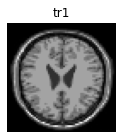

In [8]:
plt.figure(figsize=(2, 2))
plt.imshow(next(iter(tr1))[0, :, :, 0], cmap='gray')
plt.title('tr1')
plt.axis('off')
plt.show()

### Data Preprocessing


1.   Normalization of Images
2.   Reshape Images
3.   Shuffle Data


#### Normalization of Images between [-1, 1]
Pixel Normalization with zero center

In [9]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32) # convert all the pixel values to float2 data type
    image = (image / 127.5) - 1
    return image

In [10]:
def preprocess_image_train(image):
    # random flipping or mirroring to prevent overfitting
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

#### Declare Buffer Size, Batch Size and Dimensions of Noise

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # let the algorithm decide how much batches it wants to load parallely
BATCH_SIZE = 43
NOISE_DIM = 100

#### Shuffle the data and store in Batches
shuffle - Randomly shuffles the elements of this dataset.

batch - Combines consecutive elements of this dataset into batches.

In [12]:
# preprocess all the training images and shuffle it
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BATCH_SIZE)

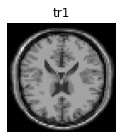

In [13]:
sample_tr1 = next(iter(tr1))
plt.figure(figsize=(2, 2))
plt.imshow(sample_tr1[0].numpy()[:, :, 0]*127.5+127.5, cmap='gray')
plt.title('tr1')
plt.axis('off')
plt.show()

### Model Building


1.   Generator Model Building
2.   Discriminator Model Building

#### Generator Model Building using Transposed Convolutional Layers

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # dense layer to map noise to more neurons
    model.add(tf.keras.layers.Dense(4*4*256, use_bias=False, input_shape=(NOISE_DIM,))) # 1-D
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 256)))
    
    # One set of upsampling layer (conv2D + Batch Norm + Leaky relu)
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), use_bias=False, padding='same', activation='tanh'))
    
    return model

Initialize the Generator model and print the architecture. Notice how the noise is being upsample from size (100) to (64, 64, 1) using upsampling by Transposed convolution

In [15]:
generator = make_generator_model()
plot_model(generator, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


#### Generate Image through a Raw model
Untrained model would generate noisy sample.

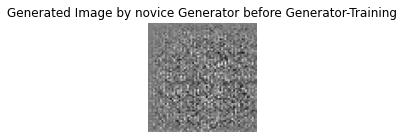

In [16]:
constant_noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(constant_noise, training=False)

plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0]*127.5+127.5, cmap='gray')
plt.title('Generated Image by novice Generator before Generator-Training')
plt.axis('off')
plt.show()

#### Discriminator Model Building using Convolutional Layers

Discriminator downsamples the image to classify it into two classes. For downsampling we use traditional convolution neural network.

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), use_bias=False,
                                     input_shape=[IMAGE_DIM, IMAGE_DIM, 1]))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(1, (5, 5), strides=(1, 1)))
    
    model.add(tf.keras.layers.Flatten())

    return model

Initialize the Discriminator model and print the architecture. Notice how the image is being downsampled from size (64,64,1) to (1) using donwsampling by convolution.

In [18]:
discriminator = make_discriminator_model()
plot_model(discriminator, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Discriminator is also novice, so it outputs random value

In [19]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00035409]], shape=(1, 1), dtype=float32)


### Model Training


1.   Loss Type
2.   Discriminator Loss
3.   Generator Loss
4.   Optimizer
5.   Checkpoint Initialization
6.   Training Flow

#### Declare Binary Cross Entropy Loss since we'll calculate Loss on Discriminator which is a classifier

In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Calculate Discriminator Loss
It consists of two types of losses

1.    Loss on Real Data
2.    Loss on Fake Data

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # real output = discrminator(real_images)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # fake output = discrminator(fake/generated_images)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator Loss
It has only one type of loss - Discriminator Loss on Generated data

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Using Adam Optimizer

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We will train our model for 100 epochs

In [24]:
EPOCHS = 100

#### Checkpoint Initialization
Initialize checkpoints to save models

In [25]:
# the directory to save the chekcpoints
checkpoint_dir = './training_checkpoints'

# list all the models and optimizers to save for checkpoints
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# initialize a checkpoint manager, which will include how many checkpoints do we want to keep
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

#### Training FLow
Below Function performs one Flow of Batch Training

In [26]:
@tf.function
def train_step(images):
    # initialize noise of (batch size, noise dim) using tf.random.normal()
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # get generated image output by generator, give noise as input
        generated_images = generator(noise, training=True)
        
        # calculate discriminator's prediction on real and fake data
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # calculate generator and discriminator loss by calling function defined earlier
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # calculate the gradients using tape.gradient, pass the loss and learnable variables as parameters.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # apply the gradients on the optimizers to update the model weights. pass gradient and trainable variables as parameters.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### Train the DCGAN Model for several Epochs
Loop training function for number of epochs and also show the output at each step. <p>
Note how Generator is getting better at producing realistic images epoch by epoch

In [29]:
!mkdir gen_images

Generated Image by Generator for Epoch: 100


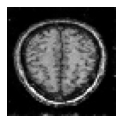

Saving checkpoint for epoch 100 at ./training_checkpoints/ckpt-124


In [30]:
# mention how many epochs to train
for epoch in range(1, EPOCHS+1):
    # iterate for each batch in the dataset
    for image_batch in tr1:
        # call the function we defined earlier to perform the training of one batch
        train_step(image_batch)
    
    display.clear_output(wait=True)
    
    # get predictions from generator to show the generated image, this gives us the idea of training improvement
    generated_image = generator(constant_noise, training=False)
    print('Generated Image by Generator for Epoch: '+str(epoch))

    fig = plt.figure(figsize=(2, 2))
    plt.imshow(generated_image[0, :, :, 0]*127.5+127.5, cmap='gray')
    plt.axis('off')
    plt.savefig('gen_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    ckpt_save_path = ckpt_manager.save()    
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Generating a GIF of Generated Images
After Training let's use our Generators to produce various images from training.
Notice the Quality of results we are getting.

In [32]:
# name your gif file
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('gen_images/image*.png')
    filenames = sorted(filenames)
    
    # iterate for all the images we have generated
    for filename in filenames:
        # read images one by one and append into the gif
        image = imageio.imread(filename)
        writer.append_data(image)
    
    # read the last image and append into the animated gif
    image = imageio.imread(filename)
    writer.append_data(image)

Install tensorflow_docs to embed the GIF files in the notebook

In [33]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-jg_s619d
     |████████████████████████████████| 1.0 MB 10.1 MB/s eta 0:00:01
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.069c6d4cbb98ed4c17cbe4629f177dcfbf3fbf53d_-py3-none-any.whl size=145191 sha256=214b342676f788d9c73b8f648693d74980d77dfb472d8c3f71841e22e6536f85
  Stored in directory: /tmp/pip-ephem-wheel-cache-jvcfgs_8/wheels/27/ca/30/9fb73780f8e8eb5a8321ae35616b0e9609f33e6c6f4071e8dd
Successfully built tensorflow-docs
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.13.0
    Uninstalling protobuf-3.13.0:
      Successfully uninstalled protobuf-3.13.0
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.



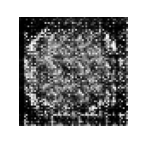

In [34]:
# use embed.embed_file(file) to embed the GIF
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)